In [1]:
# import libraries

import os
import numpy as np
import pandas as pd
import psycopg2
from dotenv import load_dotenv

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# connect to Redshift

load_dotenv()
dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

connect = psycopg2.connect(dbname=dbname, host=host, port=port, user=user, password=password)
cursor = connect.cursor()

In [3]:
# Use the read_sql() function to query this table and store the output as a variable

query = """
SELECT ot.*,
        case when sd.description = '?' or sd.description is null then 'Unknown' else sd.description end as description
FROM bootcamp1.online_transactions ot
LEFT JOIN bootcamp1.stock_description sd ON ot.stock_code = sd.stock_code
WHERE ot.customer_id <> '' 
AND ot.stock_code NOT IN ('BANK CHARGES', 'POSTAGE', 'D', 'M', 'CRUK')
AND ot.quantity > 0 """

online_transaction = pd.read_sql(query,connect)

In [4]:
# Remove duplicates and fix invoice_date type

online_transaction_cleaned = online_transaction.drop_duplicates(keep='first')
online_transaction_cleaned.invoice_date = pd.to_datetime(online_transaction_cleaned.invoice_date, format="%Y-%m-%d %H:%M:%S")

### Top ten most popular geographical locations

In [5]:
online_transaction_cleaned.groupby("country").customer_id.nunique().sort_values(ascending=False).head(10)

country
United Kingdom    3917
Germany             94
France              87
Spain               30
Belgium             25
Switzerland         21
Portugal            19
Italy               14
Finland             12
Austria             11
Name: customer_id, dtype: int64

### Country with the most spend

In [6]:
online_transaction_cleaned["total_price"] = online_transaction_cleaned.price*online_transaction_cleaned.quantity
online_transaction_cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price
0,536365,85123A,6,2010-12-01 08:26:00,2.55,u1785,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,15.30
1,536365,84029E,6,2010-12-01 08:26:00,3.39,u1785,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34
2,536366,22632,6,2010-12-01 08:28:00,1.85,u1785,United Kingdom,HAND WARMER RED POLKA DOT,11.10
3,536368,22914,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,BLUE COAT RACK PARIS FASHION,14.85
4,536367,22749,8,2010-12-01 08:34:00,3.75,u13047,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,30.00


In [7]:
online_transaction_cleaned.groupby(by="country").total_price.sum().sort_values(ascending=False).index[0]

'United Kingdom'

### Invoices across month

In [8]:
online_transaction_cleaned["year"] = online_transaction_cleaned["invoice_date"].dt.year
online_transaction_cleaned["month"] = online_transaction_cleaned["invoice_date"].dt.month
online_transaction_cleaned.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price,year,month
0,536365,85123A,6,2010-12-01 08:26:00,2.55,u1785,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,15.30,2010,12
1,536365,84029E,6,2010-12-01 08:26:00,3.39,u1785,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34,2010,12
2,536366,22632,6,2010-12-01 08:28:00,1.85,u1785,United Kingdom,HAND WARMER RED POLKA DOT,11.10,2010,12
3,536368,22914,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,BLUE COAT RACK PARIS FASHION,14.85,2010,12
4,536367,22749,8,2010-12-01 08:34:00,3.75,u13047,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,30.00,2010,12


In [9]:
year_2010 = online_transaction_cleaned.loc[online_transaction_cleaned["year"] == 2010]
year_2010.month.value_counts()

month
12    26098
Name: count, dtype: int64

In [10]:
year_2011 = online_transaction_cleaned.loc[online_transaction_cleaned["year"] == 2011]
year_2011.month.value_counts()

month
11    64277
10    49696
9     40439
5     28724
6     27507
8     27368
3     27301
7     27123
4     22758
1     21264
2     19993
12    17319
Name: count, dtype: int64

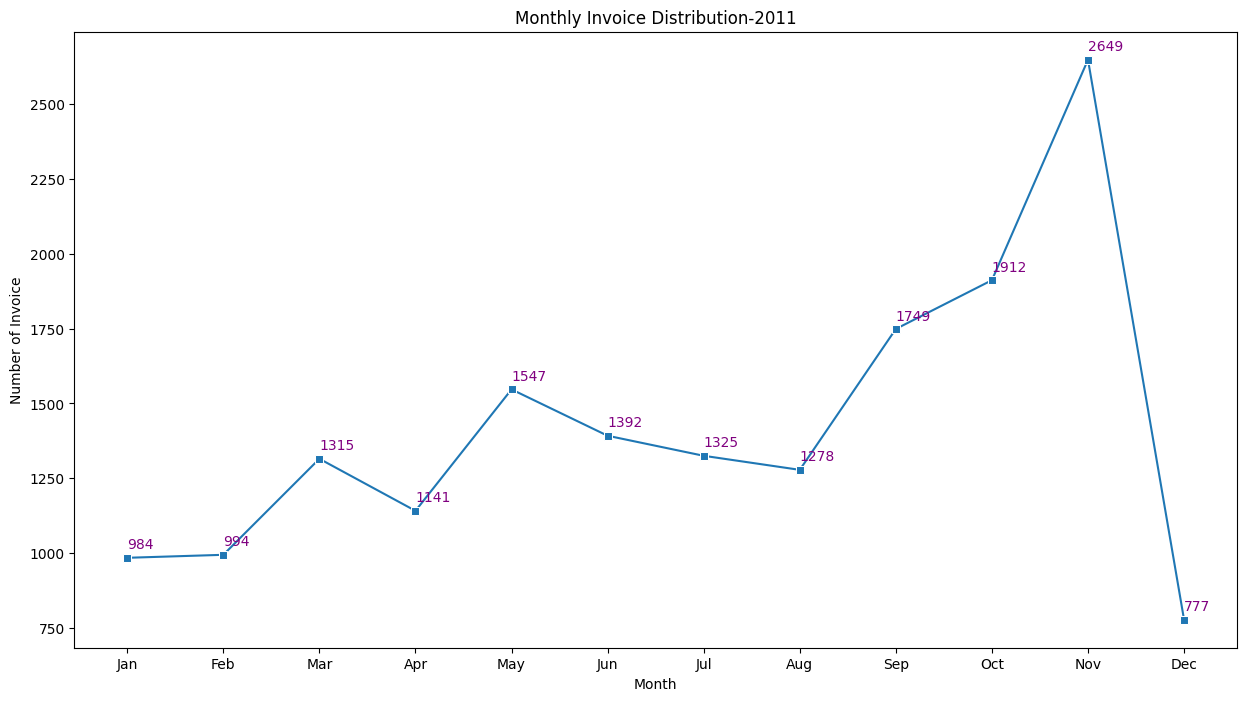

In [11]:
monthly_invoice_distribution = year_2011.groupby(by="month").invoice.nunique()

fig = plt.figure(figsize=(15,8))

ax = sns.lineplot(x=monthly_invoice_distribution.index, y=monthly_invoice_distribution.values, marker='s')

ax.set_title('Monthly Invoice Distribution-2011')
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel("Number of Invoice");


for x, y in zip(monthly_invoice_distribution.index, monthly_invoice_distribution.values):
 plt.text(x = x,
 y = y+30,
 s = '{:.0f}'.format(y),
 color = 'purple')

### Week day of the highest number of transaction

In [12]:
year_2011["week_day"] = year_2011["invoice_date"].dt.weekday
year_2011.head()

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price,year,month,week_day
18082,539993,21498,25,2011-01-04 10:00:00,0.42,u13313,United Kingdom,RED RETROSPOT WRAP,10.5,2011,1,1
18083,539993,20682,6,2011-01-04 10:00:00,3.25,u13313,United Kingdom,RED RETROSPOT CHILDRENS UMBRELLA,19.5,2011,1,1
18084,539993,22896,6,2011-01-04 10:00:00,2.55,u13313,United Kingdom,PEG BAG APPLES DESIGN,15.3,2011,1,1
18085,539993,22808,12,2011-01-04 10:00:00,2.95,u13313,United Kingdom,SET OF 6 T-LIGHTS EASTER CHICKS,35.4,2011,1,1
18086,540001,22060,6,2011-01-04 10:22:00,9.95,u18097,United Kingdom,LARGE CAKE STAND HANGING HEARTS,59.7,2011,1,1


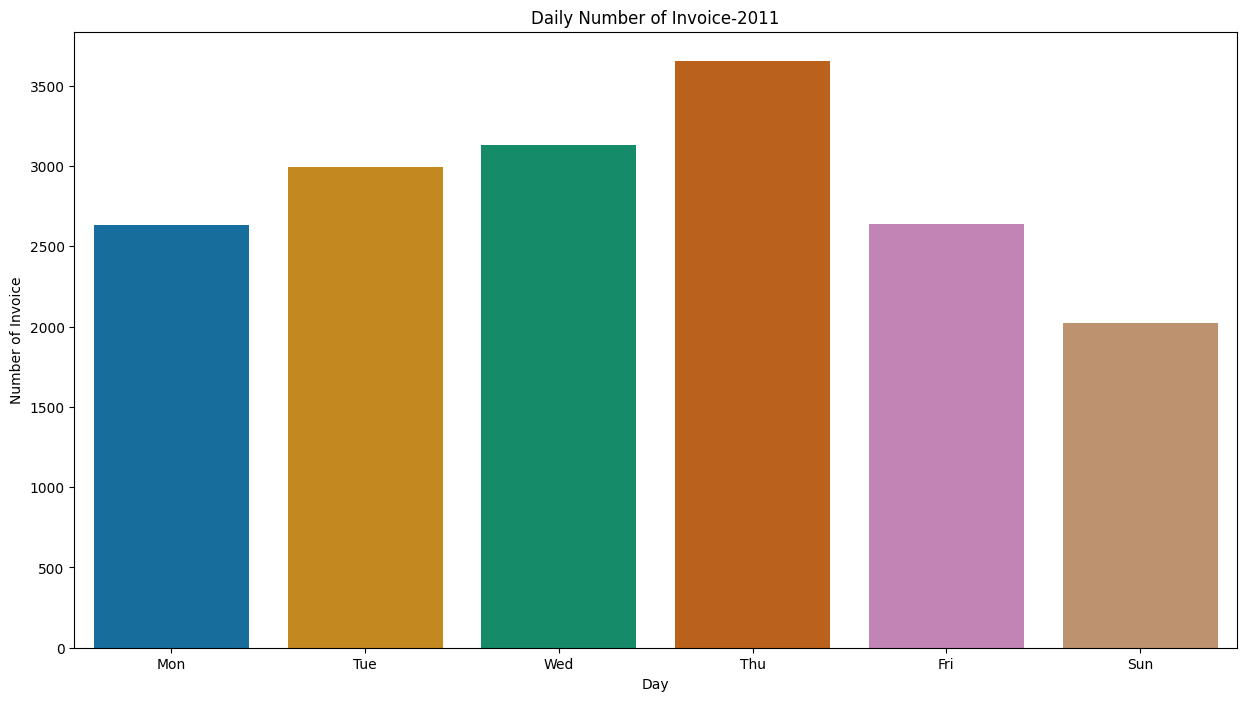

In [13]:
week_day_invoice_count = year_2011.groupby(by="week_day").invoice.nunique()

fig = plt.figure(figsize=(15,8))

ax = sns.barplot(x=week_day_invoice_count.index, y=week_day_invoice_count.values, palette="colorblind")
ax.set_xticks(range(0,6))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sun'])
ax.set_title('Daily Number of Invoice-2011')
ax.set_xlabel('Day')
ax.set_ylabel("Number of Invoice");

### Identify customers that have spent more than the average user

In [14]:
average_price_per_user = online_transaction_cleaned.groupby("customer_id").total_price.sum().mean()

In [15]:
s = (online_transaction_cleaned.groupby("customer_id").total_price.sum() > 
    average_price_per_user)
user_id_more_than_average = list(s[s].index)

In [16]:
online_transaction_cleaned[online_transaction_cleaned.customer_id.isin(user_id_more_than_average)]

,invoice,stock_code,quantity,invoice_date,price,customer_id,country,description,total_price,year,month
0,536365,85123A,6,2010-12-01 08:26:00,2.55,u1785,United Kingdom,CREAM HANGING HEART T-LIGHT HOLDER,15.30,2010,12
1,536365,84029E,6,2010-12-01 08:26:00,3.39,u1785,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.,20.34,2010,12
2,536366,22632,6,2010-12-01 08:28:00,1.85,u1785,United Kingdom,HAND WARMER RED POLKA DOT,11.10,2010,12
3,536368,22914,3,2010-12-01 08:34:00,4.95,u13047,United Kingdom,BLUE COAT RACK PARIS FASHION,14.85,2010,12
4,536367,22749,8,2010-12-01 08:34:00,3.75,u13047,United Kingdom,FELTCRAFT PRINCESS CHARLOTTE DOLL,30.00,2010,12
...,...,...,...,...,...,...,...,...,...,...,...
405126,581585,84879,16,2011-12-09 12:31:00,1.69,u15804,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,27.04,2011,12
405127,581585,22726,8,2011-12-09 12:31:00,3.75,u15804,United Kingdom,ALARM CLOCK BAKELIKE GREEN,30.00,2011,12
405128,581585,84692,25,2011-12-09 12:31:00,0.42,u15804,United Kingdom,BOX OF 24 COCKTAIL PARASOLS,10.50,2011,12
405129,581585,23328,4,2011-12-09 12:31:00,3.75,u15804,United Kingdom,SET 6 SCHOOL MILK BOTTLES IN CRATE,15.00,2011,12


### Top 10 customer with the most purchase

In [17]:
online_transaction_cleaned.groupby("customer_id").invoice.nunique().sort_values(ascending=False).head(10)

customer_id
u12748    206
u14911    199
u17841    124
u13089     97
u15311     91
u14606     91
u12971     86
u14646     74
u16029     63
u13408     62
Name: invoice, dtype: int64

### Customers have spent the least amount

In [18]:
online_transaction_cleaned.groupby("customer_id").total_price.sum().sort_values().head(10)

customer_id
u13256     0.00
u16738     3.75
u16454     5.90
u14792     6.20
u17956    12.75
u16878    13.30
u13307    15.00
u17763    15.00
u16093    17.00
u16953    20.80
Name: total_price, dtype: float64

### Top 10 item the most sold

In [19]:
online_transaction_cleaned.groupby("description").quantity.sum().sort_values(ascending=False).head(10)

description
Unknown                               99299
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
POPCORN HOLDER                        49160
JUMBO BAG RED RETROSPOT               46078
CREAM HANGING HEART T-LIGHT HOLDER    36763
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
RABBIT NIGHT LIGHT                    27153
Name: quantity, dtype: int64

### Customer churn rate

In [20]:
first_order = online_transaction_cleaned.groupby("customer_id")["invoice_date"].min()
last_order = online_transaction_cleaned.groupby("customer_id")["invoice_date"].max()

In [21]:
lifetime = pd.merge(first_order,last_order, on="customer_id", how="inner")
lifetime["customer_lifetime"] = abs(lifetime["invoice_date_x"]-lifetime["invoice_date_y"])
lifetime.head()

,invoice_date_x,invoice_date_y,customer_lifetime
customer_id,,,
u12346,2011-01-18 10:01:00,2011-01-18 10:01:00,0 days 00:00:00
u12347,2010-12-07 14:57:00,2011-12-07 15:52:00,365 days 00:55:00
u12348,2010-12-16 19:09:00,2011-09-25 13:13:00,282 days 18:04:00
u12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0 days 00:00:00
u1235,2011-02-02 16:01:00,2011-02-02 16:01:00,0 days 00:00:00


In [22]:
non_returners = lifetime.loc[lifetime["invoice_date_x"] == lifetime["invoice_date_y"]]
non_returners.customer_lifetime.value_counts()

customer_lifetime
0 days    1499
Name: count, dtype: int64

In [23]:
# calculating customer churn rate

non_returners.reset_index(inplace= True)

customer_churn_rate = round((non_returners.customer_id.nunique()/online_transaction_cleaned.customer_id.nunique())*100)
print(f"The customer churn rate is: {customer_churn_rate}%")

The customer churn rate is: 35%


### Non-returners detail

In [24]:
non_returners_detail = pd.merge(non_returners, online_transaction_cleaned, on="customer_id", how="left")
non_returners_detail.head()

,customer_id,invoice_date_x,invoice_date_y,customer_lifetime,invoice,stock_code,quantity,invoice_date,price,country,description,total_price,year,month
0,u12346,2011-01-18 10:01:00,2011-01-18 10:01:00,0 days,541431,23166,74215,2011-01-18 10:01:00,1.04,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,77183.6,2011,1
1,u12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0 days,577609,23112,2,2011-11-21 09:51:00,7.50,Italy,PARISIENNE CURIO CABINET,15.0,2011,11
2,u12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0 days,577609,21563,6,2011-11-21 09:51:00,2.95,Italy,RED HEART SHAPE LOVE BUCKET,17.7,2011,11
3,u12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0 days,577609,84978,12,2011-11-21 09:51:00,1.25,Italy,HANGING HEART JAR T-LIGHT HOLDER,15.0,2011,11
4,u12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0 days,577609,22666,6,2011-11-21 09:51:00,2.95,Italy,RECIPE BOX PANTRY YELLOW DESIGN,17.7,2011,11


## Aggregating data

### If customer ordered lastly in 2012, then it is active, otherwise it is inactive user

In [25]:
active_user = online_transaction_cleaned.groupby("customer_id", as_index=False).year.max()
active_user.columns = ["customer_id","last_order_year"]
active_user["status"] = np.where(active_user["last_order_year"]==2011,"active","inactive")
active_user.drop(columns="last_order_year", inplace=True)
active_user.head()

,customer_id,status
0,u12346,active
1,u12347,active
2,u12348,active
3,u12349,active
4,u1235,active


In [26]:
# checking inactive users' last order year

active_user.loc[active_user["status"] == "inactive"].status.value_counts()

status
inactive    120
Name: count, dtype: int64

### Classifying customer based on their favorite shopping season

In [27]:
favorite_shopping_month = online_transaction_cleaned.groupby(by="customer_id", as_index=False)["month"].agg(pd.Series.mode)
favorite_shopping_month.columns = ["customer_id","month_mostly_ordered"]
favorite_shopping_month

,customer_id,month_mostly_ordered
0,u12346,1
1,u12347,10
2,u12348,12
3,u12349,11
4,u1235,2
...,...,...
4330,u1828,3
4331,u18281,6
4332,u18282,8
4333,u18283,11


In [28]:
favorite_shopping_month["favorite_shopping_season"] = np.where(favorite_shopping_month["month_mostly_ordered"].isin([3,4,5]), "Spring", \
                                                        np.where(favorite_shopping_month["month_mostly_ordered"].isin([6,7,8]), "Summer", \
                                                        np.where(favorite_shopping_month["month_mostly_ordered"].isin([9,10,11]), "Autumn", \
                                                        "Winter")))
favorite_shopping_month[["customer_id","favorite_shopping_season"]]
favorite_shopping_month.drop(columns="month_mostly_ordered",inplace=True)
favorite_shopping_month

,customer_id,favorite_shopping_season
0,u12346,Winter
1,u12347,Autumn
2,u12348,Winter
3,u12349,Autumn
4,u1235,Winter
...,...,...
4330,u1828,Spring
4331,u18281,Summer
4332,u18282,Summer
4333,u18283,Autumn


In [29]:
# checking seasonal shopping distribution

favorite_shopping_month["favorite_shopping_season"].value_counts()

favorite_shopping_season
Autumn    1762
Winter    1031
Spring     811
Summer     731
Name: count, dtype: int64

In [30]:
overall_sum = pd.merge(active_user,favorite_shopping_month, on="customer_id")
overall_sum.head()

,customer_id,status,favorite_shopping_season
0,u12346,active,Winter
1,u12347,active,Autumn
2,u12348,active,Winter
3,u12349,active,Autumn
4,u1235,active,Winter
